In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial

In [2]:
icgc_gsea_path = '../data/ICGC_ERPosHER2neg_GSEA_results.xlsx'
metabric_gsea_path = '../data/METABRIC_ERposHER2neg_GSEA_results.xlsx'
icgc_sheets = ['TILhi_Fibrohi_inflam', 'TILmed_Fibrohi_EMT', 'TumorDense_Oxidative', 'TILhi_Fibrolow', 'TumorDense']
metabric_sheets = ['TILhi_Fibrohi_inflam', 'TILmed_Fibrohi_EMT', 'TumorDense_Oxidative', 'TILhi_Fibrolow', 'TumorDense', 'Fibromed_TILlow']
ES_col = 'ES'
icgc_significance_col = 'FDR q-val'
metabric_significance_col = 'FDR_qval'

In [3]:
gsea_results = {}
collect_all_measures = []
sheet_names = [s.replace('_', ' ') for s in icgc_sheets]
for i in range(len(icgc_sheets)):
    icgc_sheet = icgc_sheets[i]
    metabric_sheet = metabric_sheets[i]
    gsea_results[icgc_sheet] = {}
    for cohort, path, sheet in (('icgc', icgc_gsea_path, icgc_sheet), 
                                ('metabric', metabric_gsea_path, metabric_sheet)):
        gsea_results[icgc_sheet][cohort] = pd.read_excel(path, sheet_name=sheet, engine='openpyxl')
        collect_all_measures = collect_all_measures + list(gsea_results[icgc_sheet][cohort][ES_col])

In [4]:
qval_threshold = 0.25
nsheets = len(icgc_sheets)
constant_subtract = np.nanmean(collect_all_measures)
sim_matrix = np.zeros((nsheets, nsheets))
size_matrix = np.zeros((nsheets, nsheets))
for i in range(nsheets):
    for j in range(nsheets):
        icgc = gsea_results[icgc_sheets[i]]['icgc'].dropna(axis=0, subset=[ES_col, icgc_significance_col]).copy()
        icgc = icgc[icgc[icgc_significance_col] < qval_threshold]
        metabric = gsea_results[metabric_sheets[j]]['metabric'].dropna(axis=0, subset=[ES_col, metabric_significance_col]).copy()
        metabric = metabric[metabric[metabric_significance_col] < qval_threshold]
        m = icgc.merge(metabric, how='inner', left_on='NAME', right_on='NAME', suffixes=('_icgc', '_metabric'))
        size_matrix[i, j] = m.shape[0]
        if m.shape[0] < 1:
            sim_matrix[i, j] = np.nan
        else:
            sim_matrix[i, j] = 1 - spatial.distance.cosine(m[ES_col + '_icgc'].values - constant_subtract, m[ES_col + '_metabric'].values - constant_subtract)
            #sim_matrix[i, j] = 1 - spatial.distance.euclidean(m[ES_col + '_icgc'].values, m[ES_col + '_metabric'].values)

In [5]:
sim_matrix

array([[0.9817512 , 0.91841379,        nan,        nan,        nan],
       [       nan, 0.9313928 ,        nan,        nan,        nan],
       [       nan,        nan, 1.        ,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan]])

In [6]:
size_matrix

array([[6., 5., 0., 0., 0.],
       [0., 7., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

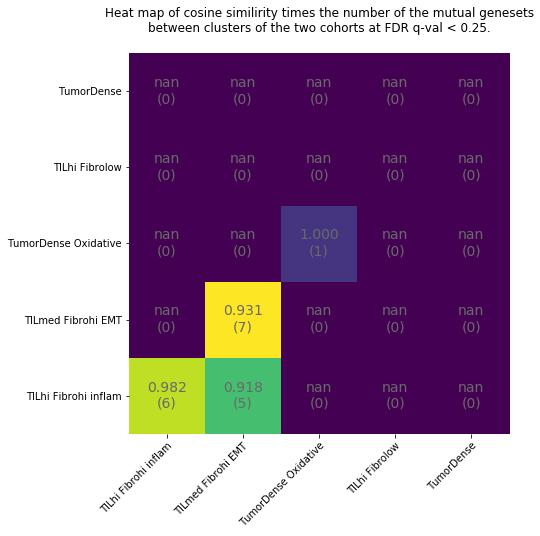

In [7]:
fig = plt.figure(figsize=(7, 7))
ax = fig.gca()
fig.patch.set_facecolor('white')

im = plt.imshow(np.nan_to_num(sim_matrix, nan=-1) * size_matrix, aspect='equal', origin='lower')

ax.set_xticks(np.arange(sim_matrix.shape[1]))
ax.set_yticks(np.arange(sim_matrix.shape[1]))
ax.set_xticklabels(sheet_names)
ax.set_yticklabels(sheet_names)
plt.title('Heat map of cosine similirity times the number of the mutual genesets\nbetween clusters of the two cohorts at FDR q-val < 0.25.\n', loc='center')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(sim_matrix.shape[1]):
    for j in range(sim_matrix.shape[0]):
        text = ax.text(j, i, '{:.3f}\n({})'.format(sim_matrix[i, j], int(size_matrix[i, j])), ha="center", va="center", color="dimgrey", size=14)

plt.tick_params(labelleft='on', labelbottom='on')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig('../figures/fig_GSEA_similarity.png', facecolor='w', format='png')
plt.show()

In [ ]:
##:~